# Stocks 1 - consolidate and EDA

<div style="text-align: right"> Author: Vassil Dimitrov </div>
<div style="text-align: right"> Date: 2023-07-30 </div>

This first stock analysis will be split into several modules:
- Data clean up and consolidation
- Exploratory data analysis and trends
- Model 1: time-series with SARIMAX
- Model 2: TBATS (can capture 2 seasonality trends)
- Model 3: LSTM RNN deep networks

## Prep

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

---

## Read data

In [2]:
dat = pd.read_csv('MacroTrends_Data_Download_FCEL.csv', skiprows=14)
display(dat.head())

,date,open,high,low,close,volume
0,1997-02-27,288.0002,288.0002,282.0002,285.1202,194
1,1997-02-28,282.0002,285.1202,282.0002,285.1202,25
2,1997-03-03,288.0002,288.0002,279.1202,279.1202,142
3,1997-03-04,278.8802,278.8802,278.8802,278.8802,0
4,1997-03-05,282.0002,285.1202,282.0002,285.1202,136


---

## Tidy up data

### Column Names and Types

#### Names

First, drop all white spaces from dataframe names.

In [3]:
dat.rename(columns = lambda x: x.strip(), inplace=True)
# Sanity check:
print(dat.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


#### Types

Check the type for each column.

In [4]:
print(dat.dtypes)

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object


In [5]:
display(dat.head(5))

,date,open,high,low,close,volume
0,1997-02-27,288.0002,288.0002,282.0002,285.1202,194
1,1997-02-28,282.0002,285.1202,282.0002,285.1202,25
2,1997-03-03,288.0002,288.0002,279.1202,279.1202,142
3,1997-03-04,278.8802,278.8802,278.8802,278.8802,0
4,1997-03-05,282.0002,285.1202,282.0002,285.1202,136


##### `date`

First, convert `date` to *datetime* format.

In [6]:
# Convert to datetime
dat['date'] = pd.to_datetime(dat['date'])
# Sanity check
print(dat.head()['date'])

0   1997-02-27
1   1997-02-28
2   1997-03-03
3   1997-03-04
4   1997-03-05
Name: date, dtype: datetime64[ns]


Now check what the maximum and minimum values for each of these columns are in order to be able to assign the appropriate data type.

In [7]:
# Check max and min values:
for col in list(['close', 'open', 'high', 'low']):
    print(f'Max of "{col}":', dat[col].max())
    print(f'Min of "{col}":', dat[col].min())

Max of "close": 7416.0059
Min of "close": 0.155
Max of "open": 7653.6061
Min of "open": 0.1625
Max of "high": 7833.6063
Min of "high": 0.1889
Max of "low": 7173.3657
Min of "low": 0.134


### Null values

Find out whether there are null values.

In [8]:
print(dat.isna().sum())

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


No null values, so we can proceeed.

### Duplications

In [9]:
# Dimensions of table.
print('Current table dimensions:', dat.shape)
# Remove duplicated rows
dat.drop_duplicates(inplace=True)
# Check result
print('Table dimensions after removing duplicates:', dat.shape)

Current table dimensions: (6653, 6)
Table dimensions after removing duplicates: (6653, 6)


No duplicated rows.

Save table for future analysis.

In [10]:
dat.to_pickle('dat.pkl')

In [11]:
del dat

---

Load pickled data.

In [12]:
df = pd.read_pickle ('dat.pkl')

In [13]:
# Sanity check:
print('Dimensions:', df.shape)

Dimensions: (6653, 6)


In [14]:
df.set_index('date', inplace=True)

### Missing dates

Check the timespan:

In [15]:
first_day = df.index.min()
last_day = df.index.max()
print('Time span:', last_day - first_day)

Time span: 9654 days 00:00:00


In [16]:
full_range = pd.date_range (start=first_day, end=last_day, freq='B')
full_range.difference(df.index)

DatetimeIndex(['1997-03-28', '1997-05-26', '1997-07-04', '1997-09-01',
               '1997-11-27', '1997-12-25', '1998-01-01', '1998-01-19',
               '1998-02-16', '1998-04-10',
               ...
               '2022-09-05', '2022-11-24', '2022-12-26', '2023-01-02',
               '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29',
               '2023-06-19', '2023-07-04'],
              dtype='datetime64[ns]', length=244, freq=None)

Impute the missing dates.

In [17]:
df_clean = df.reindex(full_range)

In [20]:
df_clean.isna().sum()

open      244
high      244
low       244
close     244
volume    244
dtype: int64

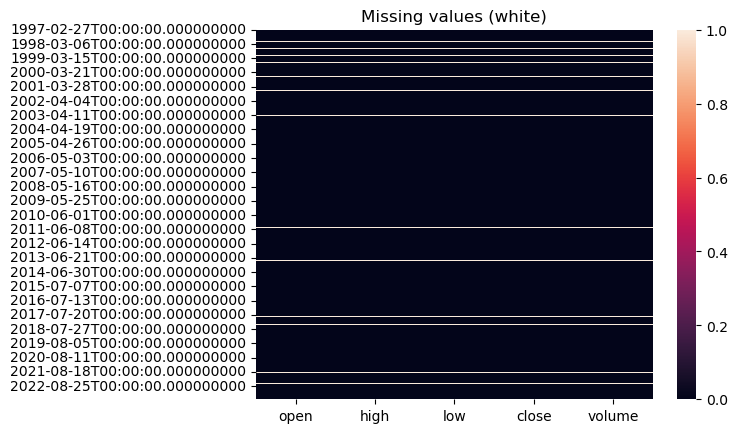

In [21]:
# shows that nulls are across rows and where they are
sns.heatmap(df_clean.isna(), vmin=0, vmax=1)
plt.title('Missing values (white)')
plt.show()

Essentially no missing values. The little missing values will be unputed using forward filling.

The imputed dates have null values for all the features. For simplicity, the features will be forward-filled to avoid null for modelling.

In [21]:
# Forward fill to impute missing values
df_clean.fillna(method="ffill").isna().sum()
df_clean = df_clean.fillna(method='ffill')

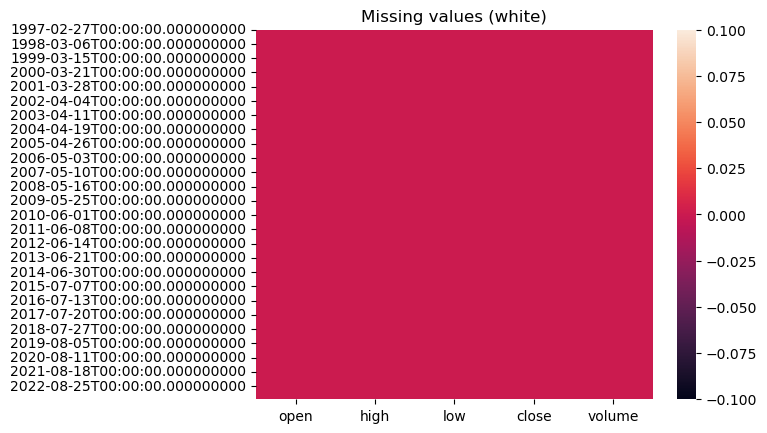

In [22]:
# shows that nulls are across rows and where they are
sns.heatmap(df_clean.isna(), vmin=0, vmax=1)
plt.title('Missing values (white)')
plt.show()

No missing values.

In [23]:
df_clean.to_pickle('df_clean.pkl')

### Subset for 2020-01-01 onwards

In [23]:
df_clean_2020 = df_clean.loc[df_clean.index >= "2020-01-01", ["open","close","volume"]]

df_clean_2020.head()

,open,close,volume
2020-01-01,NaN,NaN,NaN
2020-01-02,2.77,2.01,140123678.0
2020-01-03,1.77,2.06,55825005.0
2020-01-06,2.31,2.22,34651349.0
2020-01-07,2.17,2.08,27653256.0


## Exploratory Data Analysis

### Correlation

Look for correlations among the different variables.

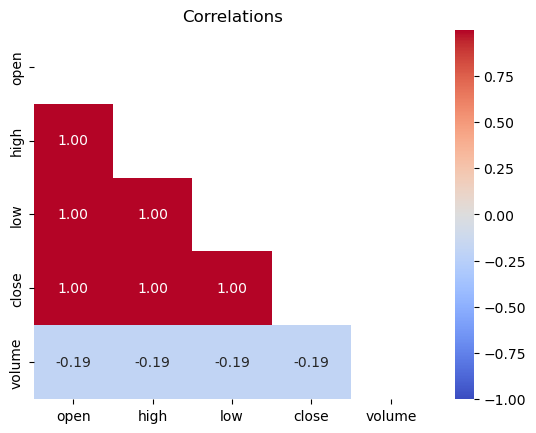

In [25]:
# Calculate correlation
corr_matrix = df_clean.corr()
# Create a mask for upper triangle (including diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Create a heatmap for variable correlation
plt.figure()
sns.heatmap(corr_matrix, 
            annot=True,
            mask=mask,
            cmap='coolwarm', fmt='.2f', vmin=-1)
plt.title('Correlations')
plt.show()

As expected, the value at closing is perfectly correlated with values at open, with high and low values throughout the day. There is also a negative correlation between volume traded and the value of the stock. Explore the 2020 data as well.

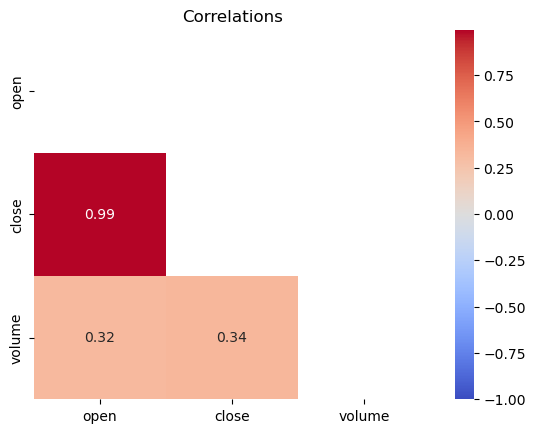

In [26]:
# Calculate correlation
corr_matrix = df_clean_2020.corr()
# Create a mask for upper triangle (including diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Create a heatmap for variable correlation
plt.figure()
sns.heatmap(corr_matrix, 
            annot=True,
            mask=mask,
            cmap='coolwarm', fmt='.2f', vmin=-1)
plt.title('Correlations')
plt.show()

Open and close are very closely correlated, as expected. Here, the open and close values are positively correlated with volume.

### Values vs Time

Let us explore how the values at open and close fluctuate with time.

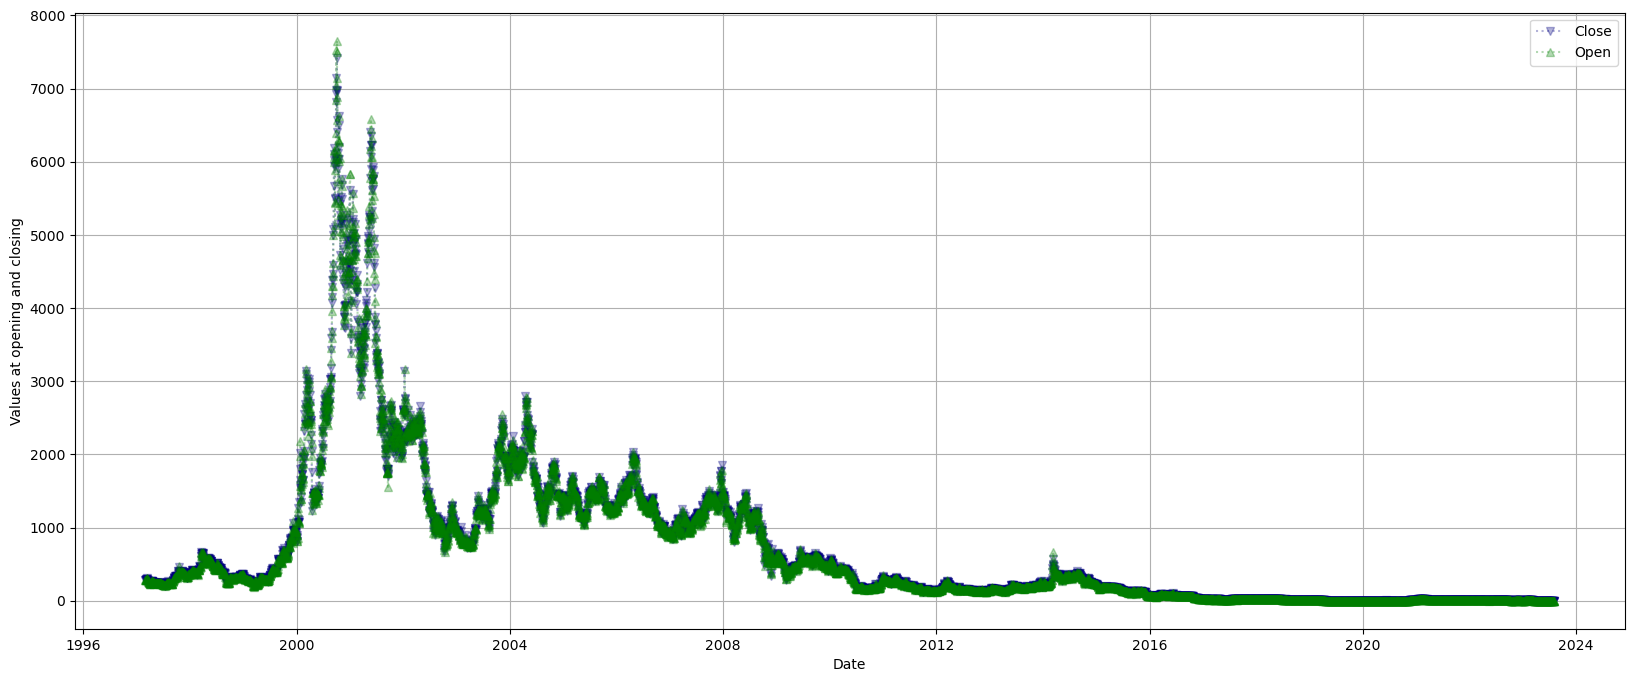

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(df_clean.index, df_clean['close'], label='Close', marker='v', color='navy', alpha=0.3, linestyle=':')
plt.plot(df_clean.index, df_clean['open'], label='Open', marker='^', color='green', alpha=0.3, linestyle=':')
plt.xlabel('Date')
plt.ylabel('Values at opening and closing')
plt.legend()
plt.grid(True)
plt.show()

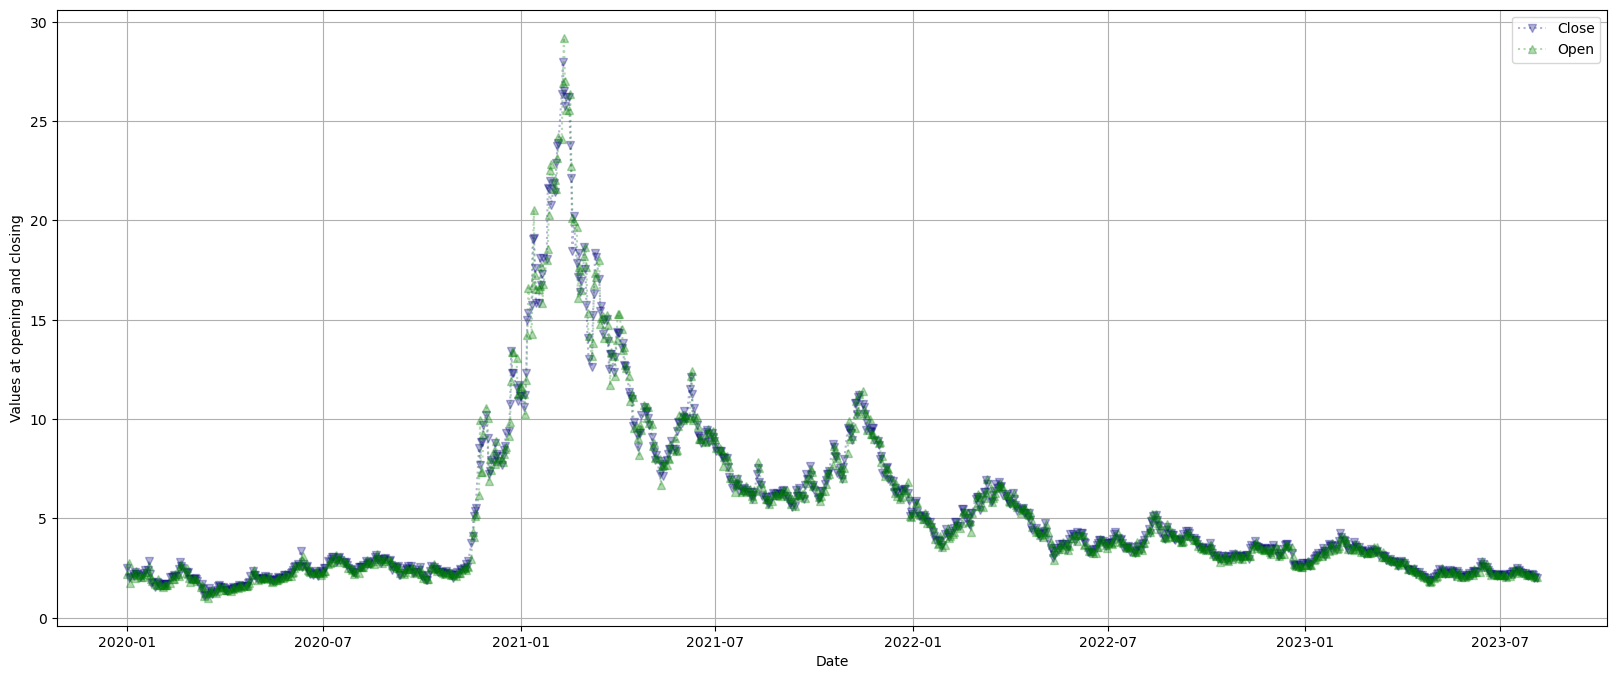

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(df_clean_2020.index, df_clean_2020['close'], label='Close', marker='v', color='navy', alpha=0.3, linestyle=':')
plt.plot(df_clean_2020.index, df_clean_2020['open'], label='Open', marker='^', color='green', alpha=0.3, linestyle=':')
plt.xlabel('Date')
plt.ylabel('Values at opening and closing')
plt.legend()
plt.grid(True)
plt.show()

It is very clear that the stocks go down for 2 consecutive days and then jump up for the third timepoint.  
  Zoom in on 2023 only.

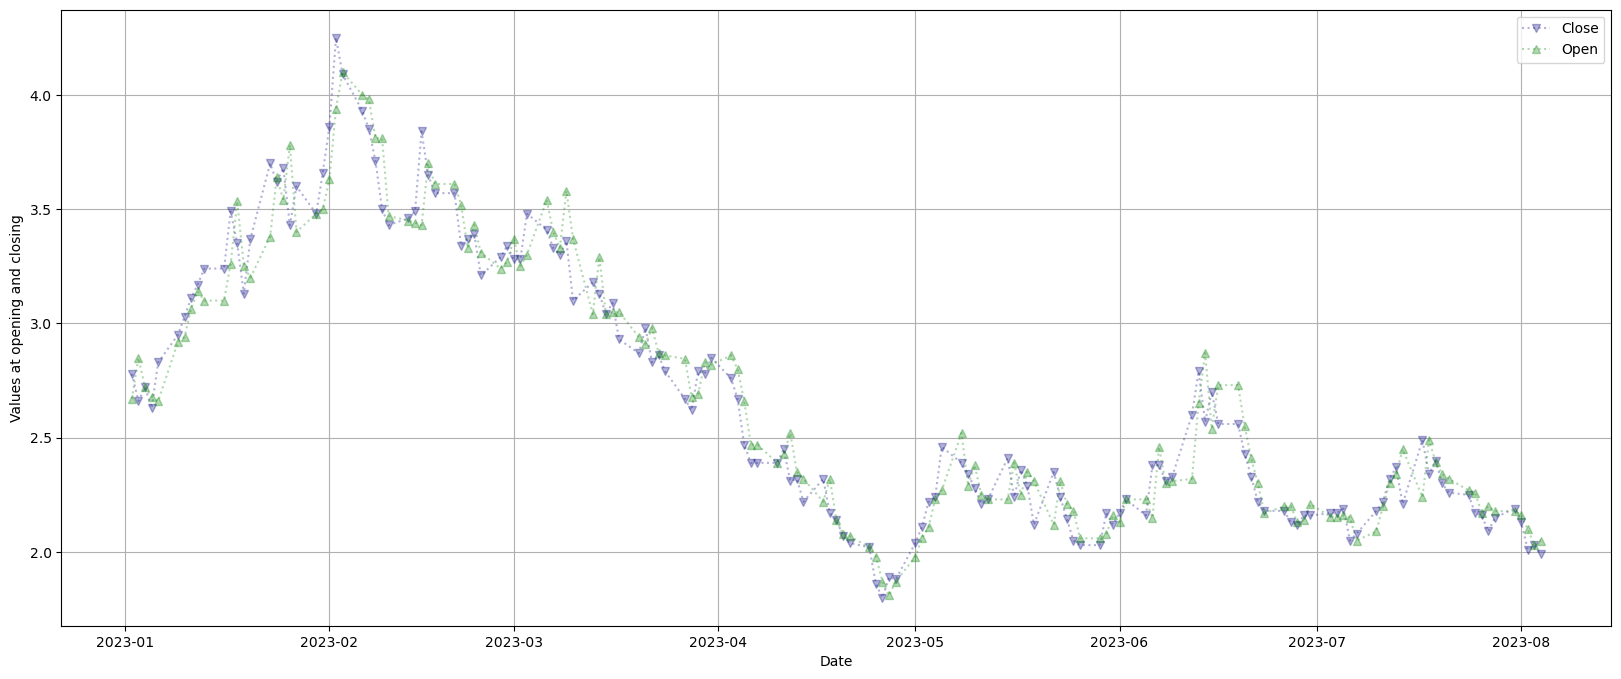

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(df_clean.loc[df_clean.index >= "2023-01-01"].index, 
         df_clean.loc[df_clean.index >= "2023-01-01"]['close'], 
         label='Close', 
         marker='v', 
         color='navy', 
         alpha=0.3, 
         linestyle=':')
plt.plot(df_clean.loc[df_clean.index >= "2023-01-01"].index, 
         df_clean.loc[df_clean.index >= "2023-01-01"]['open'], 
         label='Open', 
         marker='^', 
         color='green', 
         alpha=0.3, 
         linestyle=':')
plt.xlabel('Date')
plt.ylabel('Values at opening and closing')
plt.legend()
plt.grid(True)
plt.show()

### Daily trends

In [ ]:
# Extract data for close value (monthly average)
series_data = df_clean_2020["close"]
# Obtain rolling average:
rolling_avg = series_data.rolling(window=6).mean()

In [ ]:
# add lines for each column
fig = px.line(df_clean_2020, 
              x=df_clean_2020.index, 
              y=df_clean_2020[['open','close']].columns
              )

# Add rolling average line:
ma_line = go.Scatter(x=rolling_avg.index,
                     y=rolling_avg.values, 
                     name='trend for close', 
                     line=dict(color='black', width=3))
fig.add_trace(ma_line)

# axis labels and title
fig.update_layout(
    yaxis_title="Value", 
    legend_title="", 
    title="Stock value at opening and closing"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

### Yearly trend

Use calendar year begin.

In [32]:
df_clean_yearly = df_clean.resample('AS').mean()

# add lines for each column
fig = px.line(df_clean_yearly, 
              x=df_clean_yearly.index, 
              y=df_clean_yearly[['open','close']].columns)

# axis labels and title
fig.update_layout(
    yaxis_title="Average of values", 
    legend_title="", 
    title="Average opening and closing stock value per year"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

### Quarterly trend

In [33]:
df_clean_qtr = df_clean.resample('QS').mean()

# add lines for each column
fig = px.line(df_clean_qtr, 
              x=df_clean_qtr.index, 
              y=df_clean_qtr[['open','close']].columns)

# axis labels and title
fig.update_layout(
    yaxis_title="Average of values", 
    legend_title="", 
    title="Average opening and closing stock value per quarter"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

### Monthly trend

In [34]:
df_clean_monthly = df_clean_2020.resample('MS').mean()

# add lines for each column
fig = px.line(df_clean_monthly, 
              x=df_clean_monthly.index, 
              y=df_clean_monthly[['open','close']].columns)

# axis labels and title
fig.update_layout(
    yaxis_title="Average of values", 
    legend_title="", 
    title="Average opening and closing stock value per month"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

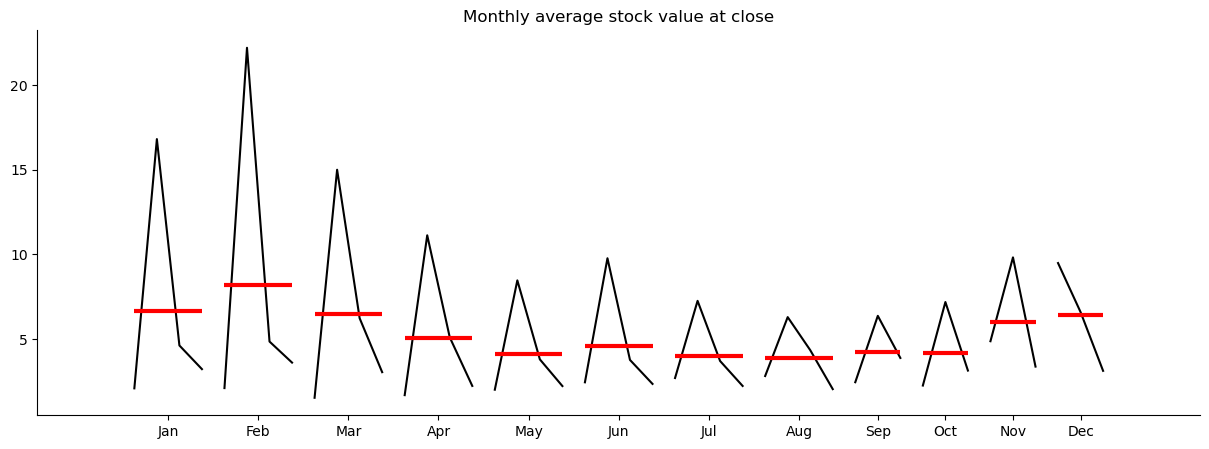

In [35]:
plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(df_clean_monthly["close"], ax=plt.gca())

plt.title("Monthly average stock value at close")
sns.despine()
plt.show()

>Based on the average trend (monthly average for each year), stock values at close seem to peek in the months of Jan, Feb, Aug and Nov, and are lowest in May and Jun, and to a certain degree in Mar and Oct.

Looking at 2022 trends only, the trend appears to be quite similar except that value is quite high in Mar and lowest in Jun, Oct and Dec.  
>So far, for 2023, Apr, May and Jun have low average monthly values and an increase may be due from July onwards.  
>However, looking at the yearly trend, the stock values appear to be decreasing steadily from 2021 onwards.

### Weekly trend

In [36]:
df_clean_weekly = df_clean_2020.resample('W').mean()

# add lines for each column
fig = px.line(df_clean_weekly, 
              x=df_clean_weekly.index, 
              y=df_clean_weekly[['open','close']].columns)

# axis labels and title
fig.update_layout(
    yaxis_title="Average of values", 
    legend_title="", 
    title="Average opening and closing stock value per week"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

### Distributions

Plot the variable distributions for each feature.

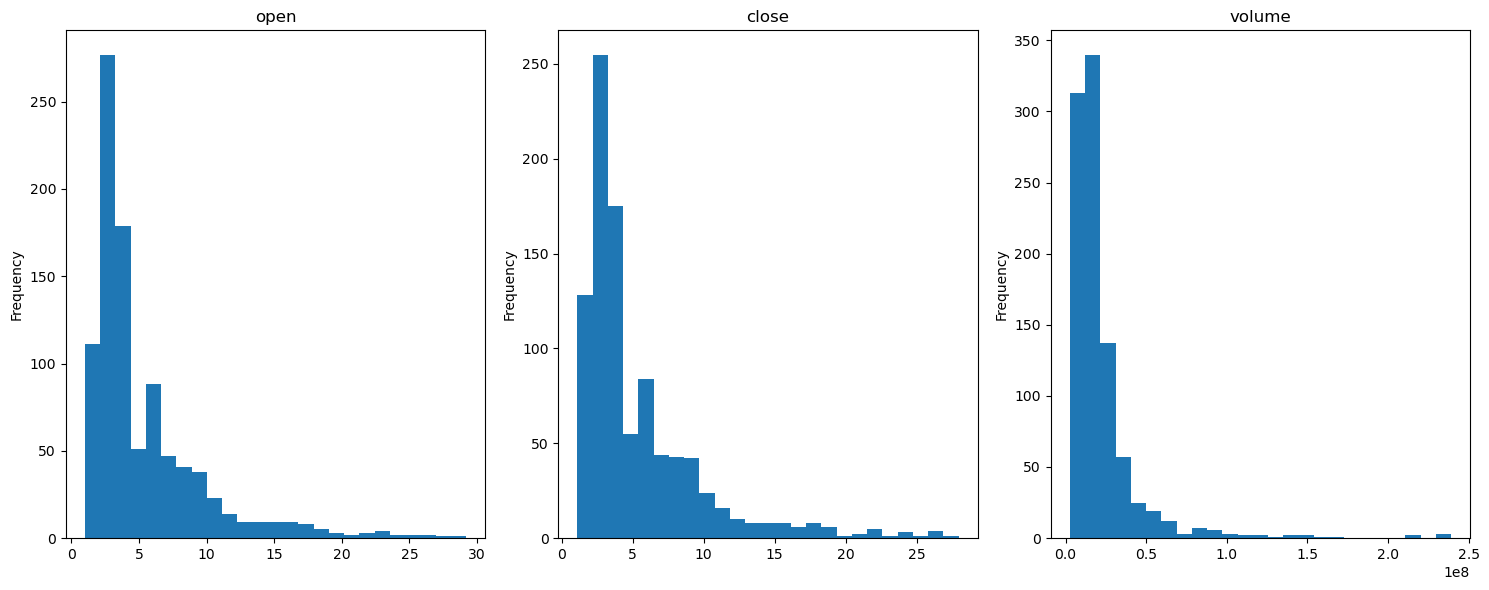

In [37]:
# Plot the distribution of all features as histograms
# Create subplots for each column in df_clean_2020
fig, axes = plt.subplots(nrows=1, ncols=len(df_clean_2020.columns), figsize=(15, 6))
for i, col in enumerate(df_clean_2020.columns):
    df_clean_2020[col].plot(kind='hist', bins=25, ax=axes[i], title=col)

plt.tight_layout()
plt.show()

`volume`, `close`, and `open`are right-skewed. These values can be transformed by taking their log. This will make them more normally distributed, which will be helpful for linear regression.

---

## Trend Seasonal Decomposition

### Days

#### Additive

In [38]:
# Decompose time series for month
decomp_days = sm.tsa.seasonal_decompose(df_clean_2020['close'], model = 'additive')

In [39]:
# add the decomposition data
df_clean_2020["Trend"] = decomp_days.trend
df_clean_2020["Seasonal"] = decomp_days.seasonal
df_clean_2020["Residual"] = decomp_days.resid
# Check:
print(df_clean_2020.columns)

Index(['open', 'close', 'volume', 'Trend', 'Seasonal', 'Residual'], dtype='object')


In [40]:
cols = ["Trend", "Seasonal", "Residual"]
colors = ['blue', 'red', 'green']

for i, col in enumerate(cols):
    figa = go.Figure(go.Scatter(x=df_clean_2020.index, 
                                y=df_clean_2020[col], 
                                name=col, 
                                line=dict(color=colors[i])
                               ))
    # Update the layout of each figure to add a range slider
    figa.update_layout(xaxis=dict(rangeslider=dict(visible=True), type='date'), title=col)
    # Display figure
    figa.show()
    del figa

>Looking at the seasonal trend, it is very clear: **the stock value at close is highest on Thursday and then dips on Friday**.

Note that the resuduals are stationary despite some cycles that can clearly be observed here after accounting for seasonal decomposition.

In [41]:
df_clean_2020.to_pickle('df_clean_2020.pkl')

---

<div style="text-align: right"> END of Consolidate & EDA module </div>
<div style="text-align: right"> Date: 2023-08-08 </div>
<div style="text-align: right"> Author: Vassil Dimitrov </div>